Pretrained networks used:
- VGG16


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd "/content/drive/MyDrive/CI/"
!pip install import-ipynb

/content/drive/MyDrive/CI
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=0308b49d9b2bca79185f7ea16aa35cfaeb8a2ca871d4a205f05a3d7cadb5052d
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import import_ipynb
import utility
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras import models,layers
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

data_path='/content/drive/MyDrive/CI/numpy_data/'

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

importing Jupyter notebook from utility.ipynb
Tensorflow Version: 2.4.1
GPU:  /device:GPU:0


# Data preprocessing


Building mass calcification dataset

In [ ]:
images, labels = utility.load_training()

train_abnormal_imgs, train_abnormal_labels = utility.mass_calcification_training_set_building(images, labels)

print('Shape:',np.shape(train_abnormal_imgs))
print('Training Labels:', train_abnormal_labels)

(2676, 150, 150)
Shape: (2676, 150, 150)
Training Labels: [0 0 0 ... 1 1 1]


Building the test set

[0.  0.5 1. ]


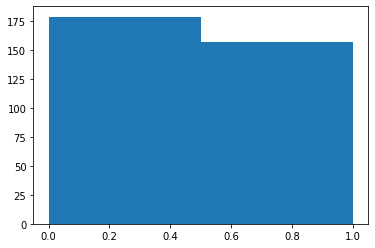

In [ ]:
test_images, test_labels = utility.load_test()

test_mc_imgs, test_mc_labels = utility.mass_calficication_test_set_building(test_images, test_labels)

ax = plt.subplot(111)
n, bins, patches =ax.hist(test_mc_labels, bins=2)
print(bins)
plt.show()

dataset overview


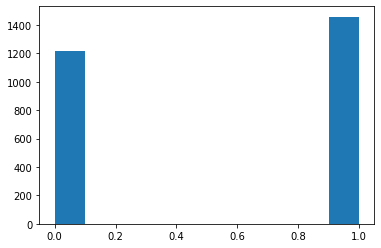

Mass Samples: 1218
Calcification Samples: 1458


In [ ]:
plt.hist(train_abnormal_labels)
plt.show()
mass_samples = len([label for label in train_abnormal_labels if label == 0])
print('Mass Samples:', mass_samples)
calcification_samples = len([label for label in train_abnormal_labels if label == 1])
print('Calcification Samples:',calcification_samples)

1218
1458
Oversampling must be done on 240 elements of the first array.
Class 0: 1458
Class 1: 1458


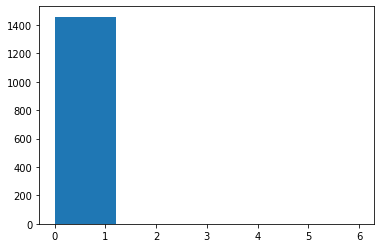

In [ ]:
#balance the datset
num_zeros = (train_abnormal_labels == 0).sum()
num_ones = (train_abnormal_labels == 1).sum()

print(num_zeros)
print(num_ones)

train_mc_imgs, train_mc_labels= utility.oversample(train_abnormal_imgs,train_abnormal_labels)

plt.hist(train_mc_labels,range=(0,6) )
plt.show()

VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

conv_base.trainable=False

conv_base.summary()

#eventual cuts on the nerwork
#conv_base_last = Model(inputs=conv_base.input, outputs=conv_base.get_layer('block4_pool').output)
#conv_base_last.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
NORMALIZATION_VALUE = 65536
BATCH_SIZE = 32

train_samples_reshaped = np.expand_dims(train_mc_imgs,3)
test_samples_reshaped = np.expand_dims(test_mc_imgs,3)

#split the dataset in training and validation
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_samples_reshaped, train_mc_labels, test_size=val_split, stratify=train_mc_labels)


train_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)

train_generator = train_datagen.flow(X_train, 
                                     y=y_train, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)

validation_generator = train_datagen.flow(X_val, 
                                     y=y_val, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)


test_generator =  test_datagen.flow(test_samples_reshaped,
                                    y=test_mc_labels,
                                    batch_size=BATCH_SIZE,
                                    seed=123)

print('Training and Validation generated.')


Training and Validation generated.


In [ ]:
model= models.Sequential()

model.add(tf.keras.Input(shape=(150,150,1)))
#DATA AUGMENTATION 
#model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123))  
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree

model.add(layers.Conv2D(3,(1,1),activation = 'relu'))
model.add(conv_base)
#model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))  #256 o 512
model.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
#model.summary()




In [ ]:
BATCH_SIZE = 32
EPOCHS =20

history = model.fit(train_generator,
          validation_data=validation_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/20
73/73 [==============================] - 23s 184ms/step - loss: 1.0789 - accuracy: 0.5104 - val_loss: 0.6788 - val_accuracy: 0.6627
Epoch 2/20
73/73 [==============================] - 11s 155ms/step - loss: 0.7138 - accuracy: 0.5571 - val_loss: 0.6556 - val_accuracy: 0.7277
Epoch 3/20
73/73 [==============================] - 12s 159ms/step - loss: 0.6852 - accuracy: 0.5625 - val_loss: 0.6368 - val_accuracy: 0.5942
Epoch 4/20
73/73 [==============================] - 12s 160ms/step - loss: 0.6290 - accuracy: 0.6454 - val_loss: 0.6729 - val_accuracy: 0.5531
Epoch 5/20
73/73 [==============================] - 12s 160ms/step - loss: 0.6176 - accuracy: 0.6514 - val_loss: 0.6063 - val_accuracy: 0.6404
Epoch 6/20
73/73 [==============================] - 12s 159ms/step - loss: 0.6029 - accuracy: 0.6573 - val_loss: 0.5665 - val_accuracy: 0.6832
Epoch 7/20
73/73 [==============================] - 11s 158ms/step - loss: 0.5492 - accuracy: 0.7324 - val_loss: 0.4850 - val_accuracy: 0.7945

In [ ]:
dir_name ="/content/drive/MyDrive/CI/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name,'mc_vgg_V5-1.h5'))

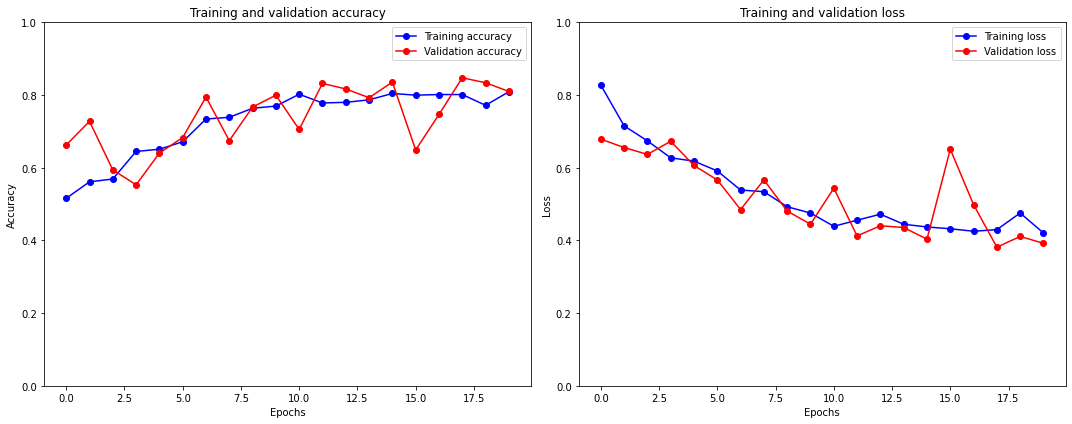

In [ ]:
utility.plot_history(history,'mc_vgg_V5-1')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

11/11 [==============================] - 1s 114ms/step - loss: 0.4257 - accuracy: 0.7857
Test Accuracy: 0.7857142686843872
Test Loss: 0.4256807863712311


Confusion matrix:
 [[158  21]
 [ 51 106]]

accuracy:
 0.7857142857142857

f2:
 0.7019867549668874

report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81       179
           1       0.83      0.68      0.75       157

    accuracy                           0.79       336
   macro avg       0.80      0.78      0.78       336
weighted avg       0.79      0.79      0.78       336

AUC:
 0.7789203999572998


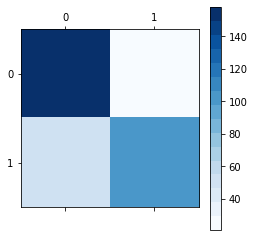

(0.7789203999572998, array([[158,  21],
        [ 51, 106]]), 0.7857142857142857, 0.7019867549668874)

In [ ]:
# ... or use predict() and sklearn to evaluate the model
test_set = test_samples_reshaped/65536
test_predictions = model.predict(test_set) 
utility.do_evaluations(test_predictions, test_mc_labels)